<a href="https://colab.research.google.com/github/joyashre/Plant-Disease-Detection/blob/main/Crop_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

--2025-05-14 10:55:13--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2025-05-14 10:55:14--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.71.136, 52.92.17.114, 52.92.34.202, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.71.136|:443... 

In [ ]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  infl

It uses the PlantVillage dataset (single folder with class subfolders).
The dataset is split into training (70%), validation (15%), and test (15%) sets.

# Step 1: Import Libraries
 These libraries help with image processing, model building, and visualization.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 2: Set Up Dataset Path
 The dataset is a single folder ('PlantVillage') with subfolders for each class (e.g., 'Tomato_Healthy').

In [ ]:
dataset_path = '/content/Plant_leave_diseases_dataset_with_augmentation'


In [ ]:
# Check if the dataset path exists to avoid errors
if not os.path.exists(dataset_path):
    print("Error: Dataset path does not exist. Please update 'dataset_path' with the correct folder location.")
    exit()

# Step 3: Prepare Data with Train, Validation, and Test Splits
 We split the dataset into:
 - Training: 70% (for learning)
 - Validation: 15%
 - Test: 15% (for final evaluation)

 We use ImageDataGenerator to load images, normalize, and augment them.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1]
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Randomly shift horizontally
    height_shift_range=0.2,  # Randomly shift vertically
    horizontal_flip=True,    # Randomly flip images
    zoom_range=0.2,         # Randomly zoom
    validation_split=0.3     # 30% for validation + test (we'll split further)
)


In [ ]:
# Load training data (70% of the dataset)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224), # Resize to 224x224 for MobileNetV2
    batch_size=32,          # Process 32 images at a time
    class_mode='categorical', # Multi-class classification
    subset='training',      # Use 70% of data
    shuffle=True
)

# Load validation + test data (30% of the dataset)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize only (no augmentation for val/test)
    validation_split=0.3     # 30% for validation + test
)

# Load validation data (half of the 30% = 15% of total)
validation_generator = val_test_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',     # Use half of the 30% (15% of total)
    shuffle=False
)

# Load test data (other half of the 30% = 15% of total)
# We use a separate ImageDataGenerator to ensure no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 43050 images belonging to 39 classes.
Found 18436 images belonging to 39 classes.
Found 61486 images belonging to 39 classes.


In [ ]:
# Get the number of classes and class names
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"Found {num_classes} classes:")
class_names

Found 39 classes:


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

# Step 4: Build the Model
We use MobileNetV2, a lightweight pre-trained model, for classification.
 - include_top=False: Remove original top layers.
 - weights='imagenet': Use pre-trained weights for better starting point.

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model to keep its weights unchanged
base_model.trainable = False

In [ ]:
# Create a new model with custom layers
model = Sequential([
    base_model,                          # MobileNetV2 base
    GlobalAveragePooling2D(),           # Reduce dimensions
    Dense(128, activation='relu'),      # Learn features
    Dense(num_classes, activation='softmax')  # Predict classes
])

In [ ]:
# Compile the model
# - optimizer='adam': Efficiently adjusts weights.
# - loss='categorical_crossentropy': For multi-class problems.
# - metrics=['accuracy']: Track performance.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Show model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,983 (9.26 MB)

 Trainable params: 168,999 (660.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 5: Train the Model
 Train using training data and validate with validation data.
 - epochs=10: Train for 10 rounds (adjust if needed).

In [ ]:
print("Starting model training...")
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3097s 2s/step - accuracy: 0.7513 - loss: 0.9113 - val_accuracy: 0.8769 - val_loss: 0.3742
Epoch 2/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3081s 2s/step - accuracy: 0.9134 - loss: 0.2626 - val_accuracy: 0.9072 - val_loss: 0.2848
Epoch 3/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3110s 2s/step - accuracy: 0.9235 - loss: 0.2278 - val_accuracy: 0.9117 - val_loss: 0.2738
Epoch 4/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3137s 2s/step - accuracy: 0.9338 - loss: 0.2008 - val_accuracy: 0.9310 - val_loss: 0.2097
Epoch 5/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3101s 2s/step - accuracy: 0.9391 - loss: 0.1838 - val_accuracy: 0.9001 - val_loss: 0.3166
Epoch 6/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3079s 2s/step - accuracy: 0.9402 - loss: 0.1803 - val_accuracy: 0.9196 - val_loss: 0.2456
Epoch 7/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3080s 2s/step - accuracy: 0.9440 - loss: 0.1675 - val_accuracy: 0.9292 - val_loss: 0.2251
Epoch 8/10
1346/1346 ━━━━━━━━━━━━━━━━━━━━ 3117s 2s/step - accuracy: 0.9443 -

# Step 6: Evaluate the Model
 Evaluate on validation and test sets, and plot training results.
 Test set evaluation gives us performance on unseen data.

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

577/577 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - accuracy: 0.9501 - loss: 0.1651
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 2578s 1s/step - accuracy: 0.9633 - loss: 0.1144
Validation Accuracy: 0.9345, Validation Loss: 0.2080
Test Accuracy: 0.9486, Test Loss: 0.1543


In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

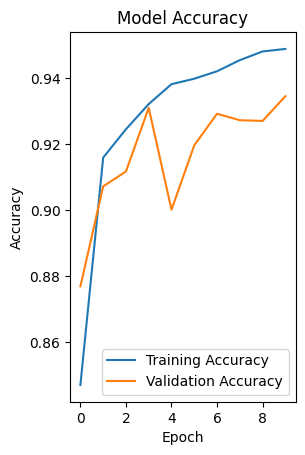

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

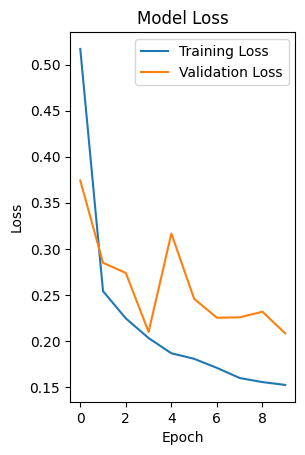

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Save the plot
plt.savefig('training_results.png')
plt.close()
print("Training plot saved as 'training_results.png'.")

Training plot saved as 'training_results.png'.


# Step 7: Evaluate Test Dataset with Predictions, Confusion Matrix, and Sample Image
 This step evaluates the test dataset, computes per-image confidence,
 plots a confusion matrix, and displays a sample image prediction.

In [ ]:


# Function to get predictions and confidence scores for test dataset
def evaluate_test_dataset(test_generator, model, class_names):
    """
    Evaluates the test dataset, prints predictions and confidence,
    and returns true/predicted labels for confusion matrix.
    Args:
        test_generator: Test data generator.
        model: Trained Keras model.
        class_names: List of class names.
    Returns:
        true_labels: List of true class indices.
        pred_labels: List of predicted class indices.
    """
    true_labels = []
    pred_labels = []
    confidence_scores = []

    # Reset generator to start from the beginning
    test_generator.reset()

    # Get one batch of test images (for efficiency, adjust if needed)
    for i in range(min(10, len(test_generator))):  # Limit to 10 batches
        images, labels = next(test_generator)
        predictions = model.predict(images, verbose=0)

        for j in range(len(images)):
            true_class = class_names[np.argmax(labels[j])]
            pred_class = class_names[np.argmax(predictions[j])]
            confidence = np.max(predictions[j]) * 100
            true_labels.append(np.argmax(labels[j]))
            pred_labels.append(np.argmax(predictions[j]))
            confidence_scores.append(confidence)
            print(f"Image {i*32+j+1}: True: {true_class}, Predicted: {pred_class}, Confidence: {confidence:.2f}%")

    return true_labels, pred_labels, confidence_scores



In [ ]:
# Function to display a sample test image with prediction
def display_sample_prediction(test_generator, model, class_names):
    """
    Displays one test image with its true and predicted labels.
    Args:
        test_generator: Test data generator.
        model: Trained Keras model.
        class_names: List of class names.
    """
    test_generator.reset()
    images, labels = next(test_generator)  # Get one batch
    img = images[0]  # Take first image
    true_class = class_names[np.argmax(labels[0])]

    # Predict
    img_array = np.expand_dims(img, axis=0)
    predictions = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
   # Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPredicted: {pred_class}, Confidence: {confidence:.2f}%")
    plt.axis('off')
    plt.savefig('sample_prediction.png')
    plt.show()
    plt.close()



In [ ]:
# Run test dataset evaluation
print("\nEvaluating test dataset...")
true_labels, pred_labels, confidence_scores = evaluate_test_dataset(test_generator, model, class_names)



Evaluating test dataset...
Image 1: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 99.68%
Image 2: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 98.78%
Image 3: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 99.96%
Image 4: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 98.42%
Image 5: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 99.94%
Image 6: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 99.27%
Image 7: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 97.23%
Image 8: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 99.99%
Image 9: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 98.31%
Image 10: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 97.65%
Image 11: True: Apple___Apple_scab, Predicted: Apple___Apple_scab, Confidence: 99.73%
Image 12: True: Apple___Apple_scab,


Displaying sample test image prediction...


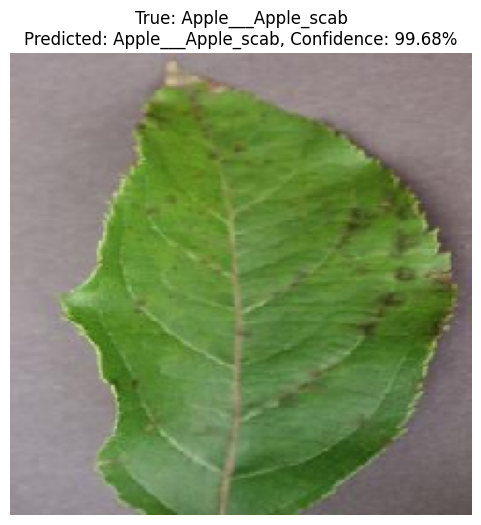

In [ ]:
# Display a sample test image
print("\nDisplaying sample test image prediction...")
display_sample_prediction(test_generator, model, class_names)



# Step 8: Save the Model
 Save for future use

In [ ]:

model.save('plant_disease_model.h5')
print("Model saved as 'plant_disease_model.h5'.")

Model saved as 'plant_disease_model.h5'.
